1. Model Selection -> benchmark accuracy performance
2. Hyper param tuning?
3. Batch processing for optimization

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!pip install timm annoy

In [ ]:
import pandas as pd
import numpy as np
import torchvision
import requests
import random
import torch
from torch import nn
from torchvision import transforms
from google.colab import drive
from transformers import (
    ViTForImageClassification, ViTModel, ViTFeatureExtractor,
    AutoModelForImageClassification, BeitFeatureExtractor, ViTMAEModel,
    DeiTFeatureExtractor, DeiTModel, DetrFeatureExtractor, DetrForSegmentation,
    AutoFeatureExtractor, ViTMAEForPreTraining,
    DeiTForImageClassificationWithTeacher, ImageGPTForCausalImageModeling,
    ImageGPTFeatureExtractor, ImageGPTForImageClassification,
)

from PIL import Image
from annoy import AnnoyIndex
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from collections import defaultdict

np.random.seed(42)

In [ ]:
drive.mount('/gdrive')
!ls '/gdrive/My Drive/cse6242_project/Data'
!unzip -q '/gdrive/My Drive/cse6242_project/Data/celeba'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
accuracy_vs_num_images_18k.csv	celeba.zip
celeba_beit_index.ann		celeb_jpeg
celeba_vit_finetuned_index.ann	identity_CelebA.txt
replace img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# read pre-built index
def get_annoy_index(df, 
                    dim=768, 
                    metric='euclidean', 
                    index_file='/gdrive/My Drive/cse6242_project/Data/celeba_vit_finetuned_index.ann'
                    ):
  
    print('loading annoy index...')
    idx_to_identity = df.to_dict('index')
    identity_to_idx = defaultdict(list) 
    index = AnnoyIndex(dim, metric)
    index.load(index_file)

    images, keys = [], []
    for k, v in idx_to_identity.items():
      identity_to_idx[v["identity"]].append(k)
      keys.append(k)

    return index, idx_to_identity, identity_to_idx

# create identities
def get_identities():
    print('loading data...')
    identities = pd.read_csv("/gdrive/My Drive/cse6242_project/Data/identity_CelebA.txt", sep=" ", header=None)
    identities.rename(columns={0: "file", 1: "identity"}, inplace=True) 
    identity_selection = identities.identity.unique()
    df = identities[identities.identity.isin(identity_selection)].reset_index()
    return df, identity_selection 

df, identity_selection = get_identities()
index, idx_to_identity, identity_to_idx = get_annoy_index(df)

loading data...
loading annoy index...


100%|██████████| 10177/10177 [00:22<00:00, 451.40it/s]


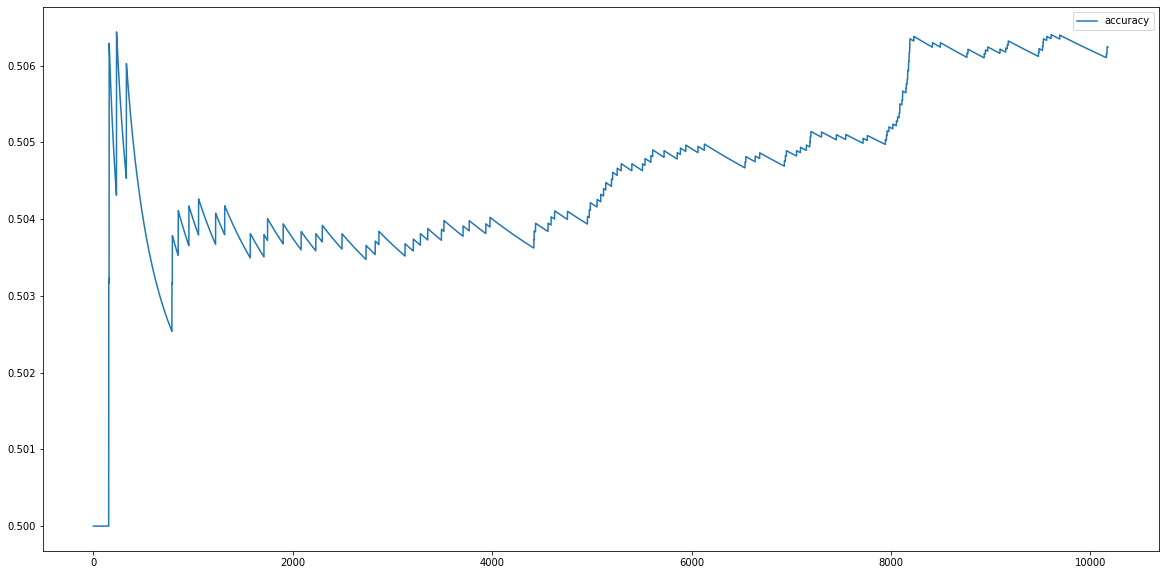

In [ ]:
test_accuracies = []
results = []
for identity in tqdm(identity_selection):
  base_image_idx = random.choice(identity_to_idx[identity])
  close_image_idx = index.get_nns_by_item(base_image_idx, 2, search_k=-1, include_distances=False)
  test_accuracies.append(retrival_accuracy(base_image_idx, close_image_idx, idx_to_identity, identity_to_idx))
  acc = np.mean(test_accuracies)
  results.append({'accuracy': acc})

pd.DataFrame(results).plot(figsize=(20, 10))

In [ ]:
df, identity_selection = prepare_dataset(n_identities=1000)
for model_identifier in models:
  model, feature_extractor, dim = init_model(model_identifier)
  index, idx_to_identity, identity_to_idx = build_annoy_index(model, feature_extractor, df, dim)

  test_accuracies = []
  for identity in tqdm(identity_selection):
    base_image_idx = random.choice(identity_to_idx[identity])
    close_image_idx = index.get_nns_by_item(base_image_idx, 5, search_k=-1, include_distances=False)
    test_accuracies.append(retrival_accuracy(base_image_idx, close_image_idx, idx_to_identity, identity_to_idx))
    acc = np.mean(test_accuracies)
    results[model_identifier].append(acc)
  print(model_identifier, 'Accuracy: ', acc)

In [ ]:
class Identity(nn.Module):
    # adds a forward layer to the backbone
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def init_model(identifier):
    print(identifier)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if identifier == 'microsoft/beit-base-patch16-224-pt22k-ft22k':
        feature_extractor = BeitFeatureExtractor.from_pretrained(identifier)
        model = AutoModelForImageClassification.from_pretrained(identifier)
        dim = 768
    elif identifier == 'google/vit-base-patch16-224':
        feature_extractor = ViTFeatureExtractor.from_pretrained(identifier)
        model = ViTForImageClassification.from_pretrained(identifier)
        dim = 768
    elif identifier == 'facebook/vit-mae-base':
        feature_extractor = AutoFeatureExtractor.from_pretrained(identifier)
        model = ViTMAEForPreTraining.from_pretrained(identifier)
        dim = 196
    elif identifier == 'facebook/deit-base-distilled-patch16-224':
        feature_extractor = DeiTFeatureExtractor.from_pretrained(identifier)
        model = DeiTForImageClassificationWithTeacher.from_pretrained(identifier)
        dim = 1000
    elif identifier == 'facebook/detr-resnet-50-panoptic':
        feature_extractor = DetrFeatureExtractor.from_pretrained(identifier)
        model = DetrForSegmentation.from_pretrained(identifier)
        dim = 768
    elif identifier == 'openai/imagegpt-small':
        feature_extractor = ImageGPTFeatureExtractor.from_pretrained(identifier)
        model = ImageGPTForImageClassification.from_pretrained(identifier) 
        dim = 2
    elif identifier == 'openai/imagegpt-large':
        feature_extractor = ImageGPTFeatureExtractor.from_pretrained(identifier)
        model = ImageGPTForCausalImageModeling.from_pretrained(identifier) 
        dim = 2

    model.classifier = Identity()
    model.eval()
    model.to(device)

    return model, feature_extractor, dim

def prepare_dataset(n_identities=100):
    print('loading data...')
    identities = pd.read_csv("/gdrive/My Drive/cse6242_project/Data/identity_CelebA.txt", sep=" ", header=None)
    identities.rename(columns={0: "file", 1: "identity"}, inplace=True) 
    identity_selection = np.random.choice(identities.identity.unique(), n_identities)
    df = identities[identities.identity.isin(identity_selection)].reset_index()
    return df, identity_selection

def build_annoy_index(model, feature_extractor, df, dim=768, batch_size=25, metric='euclidean'):
    print('building annoy index...')
    idx_to_identity = df.to_dict('index')
    identity_to_idx = defaultdict(list) 
    index = AnnoyIndex(dim, metric)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    images, keys = [], []
    for k, v in idx_to_identity.items():
      identity_to_idx[v["identity"]].append(k)
      images.append(Image.open("img_align_celeba/img_align_celeba/" + v["file"]))
      keys.append(k)

    # batched computation
    print('num images:', len(images))
    for i in tqdm(range(0, len(images), batch_size)):
      batch_im, batch_keys = images[i:i+batch_size], keys[i:i+batch_size]
      batch_encodings = feature_extractor(images=batch_im, return_tensors="pt")
      batch_pixel_values = batch_encodings['pixel_values'].to(device)
      batch_outputs = model(batch_pixel_values).logits
      for i, embedding in enumerate(batch_outputs):
        index.add_item(batch_keys[i], embedding.squeeze())

    index.build(128)
    index.save('celeba.ann')

    return index, idx_to_identity, identity_to_idx

def retrival_accuracy(base_idx, image_idx, idx_to_identity, identity_to_idx):
    true_identity = idx_to_identity[base_idx]["identity"]
    n_true_matches = len(identity_to_idx[true_identity])

    hits = []

    for idx in image_idx:
        idx_identity = idx_to_identity[idx]["identity"]

        if idx_identity == true_identity:
            hits.append(True)
        else:
            hits.append(False)

    return sum(hits) / min(len(image_idx), n_true_matches)

In [ ]:
models = [
    'google/vit-base-patch16-224',
    'facebook/deit-base-distilled-patch16-224',
    'microsoft/beit-base-patch16-224-pt22k-ft22k',
    # 'openai/imagegpt-small', # ->  super slow
    # 'openai/imagegpt-large', # -> out of RAM error
    # 'facebook/detr-resnet-50-panoptic', # -> not able to find timm package
] # , 'facebook/vit-mae-base' -> strange error during index.add_item() , 

results = defaultdict(list)
df, identity_selection = prepare_dataset(n_identities=10000)
for model_identifier in models:
  model, feature_extractor, dim = init_model(model_identifier)
  index, idx_to_identity, identity_to_idx = build_annoy_index(model, feature_extractor, df, dim)

  test_accuracies = []
  for identity in tqdm(identity_selection):
    base_image_idx = random.choice(identity_to_idx[identity])
    close_image_idx = index.get_nns_by_item(base_image_idx, 5, search_k=-1, include_distances=False)
    test_accuracies.append(retrival_accuracy(base_image_idx, close_image_idx, idx_to_identity, identity_to_idx))
    acc = np.mean(test_accuracies)
    results[model_identifier].append(acc)
  print(model_identifier, 'Accuracy: ', acc)



loading data...
facebook/deit-base-distilled-patch16-224


Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333M [00:00<?, ?B/s]

building annoy index...
num images: 125714


 31%|███       | 1547/5029 [18:29<45:19,  1.28it/s]

Retrieval Accuracy by Model

In [ ]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results.plot(title='retrieval accuracy vs annoy index size (identities)')
df_results.to_csv('accuracy_vs_num_images_10k.csv')

Accuracy vs Distance Metrics

In [ ]:
distance_metrics = ['angular', 'manhattan', 'hamming', 'dot', 'euclidean'] 
results2 = defaultdict(list)
df, identity_selection = prepare_dataset(n_identities=1000)
model_identifier = 'microsoft/beit-base-patch16-224-pt22k-ft22k'
model, feature_extractor, dim = init_model(model_identifier)

loading data...
microsoft/beit-base-patch16-224-pt22k-ft22k


building annoy index...
num images: 18804


100%|██████████| 5/5 [00:00<00:00, 40563.87it/s]

100%|██████████| 5/5 [00:00<00:00, 37991.88it/s]

100%|██████████| 5/5 [00:00<00:00, 11497.54it/s]

100%|██████████| 5/5 [00:00<00:00, 32513.98it/s]

100%|██████████| 5/5 [00:00<00:00, 6502.80it/s]

100%|██████████| 5/5 [00:00<00:00, 21377.70it/s]

100%|██████████| 5/5 [00:00<00:00, 38621.58it/s]

100%|██████████| 5/5 [00:00<00:00, 39494.39it/s]

100%|██████████| 5/5 [00:00<00:00, 39199.10it/s]

100%|██████████| 5/5 [00:00<00:00, 36408.89it/s]

100%|██████████| 5/5 [00:00<00:00, 40252.44it/s]

100%|██████████| 5/5 [00:00<00:00, 41527.76it/s]

100%|██████████| 5/5 [00:00<00:00, 12453.40it/s]

100%|██████████| 5/5 [00:00<00:00, 45003.26it/s]

100%|██████████| 5/5 [00:00<00:00, 22995.09it/s]

100%|██████████| 5/5 [00:00<00:00, 44525.52it/s]

100%|██████████| 5/5 [00:00<00:00, 40021.98it/s]

100%|██████████| 5/5 [00:00<00:00, 42281.29it/s]

100%|██████████| 5/5 [00:00<00:00, 28225.46it/s]

100%|██████████| 5/5 [00:00<00:00, 32313.59it/s]

1

microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.43525
building annoy index...
num images: 18804


100%|██████████| 5/5 [00:00<00:00, 7648.26it/s]

100%|██████████| 5/5 [00:00<00:00, 44243.71it/s]

100%|██████████| 5/5 [00:00<00:00, 43151.28it/s]

100%|██████████| 5/5 [00:00<00:00, 8927.85it/s]

100%|██████████| 5/5 [00:00<00:00, 39718.79it/s]

100%|██████████| 5/5 [00:00<00:00, 12066.47it/s]

100%|██████████| 5/5 [00:00<00:00, 31920.12it/s]

100%|██████████| 5/5 [00:00<00:00, 41201.41it/s]

100%|██████████| 5/5 [00:00<00:00, 42711.85it/s]

100%|██████████| 5/5 [00:00<00:00, 34778.64it/s]

100%|██████████| 5/5 [00:00<00:00, 41859.32it/s]

100%|██████████| 5/5 [00:00<00:00, 33394.14it/s]

100%|██████████| 5/5 [00:00<00:00, 10710.68it/s]

100%|██████████| 5/5 [00:00<00:00, 47771.12it/s]

100%|██████████| 5/5 [00:00<00:00, 31207.62it/s]

100%|██████████| 5/5 [00:00<00:00, 46603.38it/s]

100%|██████████| 5/5 [00:00<00:00, 28610.53it/s]

100%|██████████| 5/5 [00:00<00:00, 57299.23it/s]

100%|██████████| 5/5 [00:00<00:00, 37718.56it/s]

100%|██████████| 5/5 [00:00<00:00, 52038.51it/s]

10

microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4357833333333334
building annoy index...
num images: 18804


100%|██████████| 5/5 [00:00<00:00, 35424.86it/s]

100%|██████████| 5/5 [00:00<00:00, 38409.38it/s]

100%|██████████| 5/5 [00:00<00:00, 10939.76it/s]

100%|██████████| 5/5 [00:00<00:00, 36408.89it/s]

100%|██████████| 5/5 [00:00<00:00, 10275.12it/s]

100%|██████████| 5/5 [00:00<00:00, 39568.91it/s]

100%|██████████| 5/5 [00:00<00:00, 45100.04it/s]

100%|██████████| 5/5 [00:00<00:00, 15240.93it/s]

100%|██████████| 5/5 [00:00<00:00, 9446.63it/s]

100%|██████████| 5/5 [00:00<00:00, 32214.32it/s]

100%|██████████| 5/5 [00:00<00:00, 9957.99it/s]

100%|██████████| 5/5 [00:00<00:00, 9106.17it/s]

100%|██████████| 5/5 [00:00<00:00, 9271.23it/s]

100%|██████████| 5/5 [00:00<00:00, 21399.51it/s]

100%|██████████| 5/5 [00:00<00:00, 17432.68it/s]

100%|██████████| 5/5 [00:00<00:00, 24077.52it/s]

100%|██████████| 5/5 [00:00<00:00, 30131.49it/s]

100%|██████████| 5/5 [00:00<00:00, 32214.32it/s]

100%|██████████| 5/5 [00:00<00:00, 17077.79it/s]

100%|██████████| 5/5 [00:00<00:00, 29248.98it/s]

100%

microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.39355000000000007
building annoy index...
num images: 18804


100%|██████████| 5/5 [00:00<00:00, 36727.71it/s]

100%|██████████| 5/5 [00:00<00:00, 28688.81it/s]

100%|██████████| 5/5 [00:00<00:00, 34606.47it/s]

100%|██████████| 5/5 [00:00<00:00, 45990.18it/s]

100%|██████████| 5/5 [00:00<00:00, 26955.68it/s]

100%|██████████| 5/5 [00:00<00:00, 41692.88it/s]

100%|██████████| 5/5 [00:00<00:00, 30795.18it/s]

100%|██████████| 5/5 [00:00<00:00, 37449.14it/s]

100%|██████████| 5/5 [00:00<00:00, 25175.89it/s]

100%|██████████| 5/5 [00:00<00:00, 44337.25it/s]

100%|██████████| 5/5 [00:00<00:00, 42625.04it/s]

100%|██████████| 5/5 [00:00<00:00, 45889.54it/s]

100%|██████████| 5/5 [00:00<00:00, 37991.88it/s]

100%|██████████| 5/5 [00:00<00:00, 47771.12it/s]

100%|██████████| 5/5 [00:00<00:00, 40485.56it/s]

100%|██████████| 5/5 [00:00<00:00, 38060.83it/s]

100%|██████████| 5/5 [00:00<00:00, 41527.76it/s]

100%|██████████| 5/5 [00:00<00:00, 37923.18it/s]

100%|██████████| 5/5 [00:00<00:00, 49344.75it/s]

100%|██████████| 5/5 [00:00<00:00, 41859.32it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4365
building annoy index...
num images: 18804


100%|██████████| 5/5 [00:00<00:00, 36921.69it/s]

100%|██████████| 5/5 [00:00<00:00, 34267.19it/s]

100%|██████████| 5/5 [00:00<00:00, 43965.45it/s]

100%|██████████| 5/5 [00:00<00:00, 34836.41it/s]

100%|██████████| 5/5 [00:00<00:00, 45990.18it/s]

100%|██████████| 5/5 [00:00<00:00, 55627.37it/s]

100%|██████████| 5/5 [00:00<00:00, 57932.38it/s]

100%|██████████| 5/5 [00:00<00:00, 52958.38it/s]

100%|██████████| 5/5 [00:00<00:00, 57143.11it/s]

100%|██████████| 5/5 [00:00<00:00, 58254.22it/s]

100%|██████████| 5/5 [00:00<00:00, 45197.24it/s]

100%|██████████| 5/5 [00:00<00:00, 58743.75it/s]

100%|██████████| 5/5 [00:00<00:00, 42711.85it/s]

100%|██████████| 5/5 [00:00<00:00, 58743.75it/s]

100%|██████████| 5/5 [00:00<00:00, 59074.70it/s]

100%|██████████| 5/5 [00:00<00:00, 60262.99it/s]

100%|██████████| 5/5 [00:00<00:00, 44906.90it/s]

100%|██████████| 5/5 [00:00<00:00, 43329.59it/s]

100%|██████████| 5/5 [00:00<00:00, 49344.75it/s]

100%|██████████| 5/5 [00:00<00:00, 48210.39it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4365833333333334


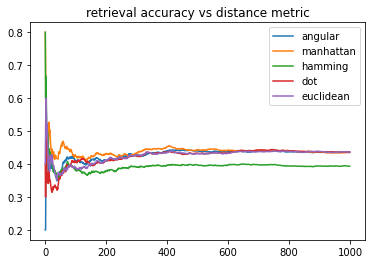

In [ ]:
for metric in distance_metrics:
  index, idx_to_identity, identity_to_idx = build_annoy_index(model, feature_extractor, df, dim, metric=metric)
  test_accuracies = []
  for identity in tqdm(identity_selection):
    base_image_idx = random.choice(identity_to_idx[identity])
    close_image_idx = index.get_nns_by_item(base_image_idx, 5, search_k=-1, include_distances=False)
    test_accuracies.append(retrival_accuracy(base_image_idx, close_image_idx, idx_to_identity, identity_to_idx))
    acc = np.mean(test_accuracies)
    results2[metric].append(acc)
  print(model_identifier, 'Accuracy: ', acc)


df_results2 = pd.DataFrame(results2)
df_results2.plot(title='retrieval accuracy vs distance metric')
df_results2.to_csv('accuracy_vs_distance_metric_18k.csv')

In [ ]:
import numpy as np

df, identity_selection = prepare_dataset(n_identities=1000)
model_identifier = 'microsoft/beit-base-patch16-224-pt22k-ft22k'
model, feature_extractor, dim = init_model(model_identifier)
index, idx_to_identity, identity_to_idx = build_annoy_index(model, feature_extractor, df, dim)

loading data...
microsoft/beit-base-patch16-224-pt22k-ft22k


Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/395M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


building annoy index...
num images: 18342


100%|██████████| 734/734 [14:02<00:00,  1.15s/it]


In [ ]:
identity_to_idx[identity]

[1351, 4361, 6028, 8729, 9110]

In [ ]:
k_values = np.arange(200, 2000, 200)
import time
np.random.seed(42)
results3 = []

for k in tqdm(k_values):
  test_accuracies = []
  times = []
  for identity in identity_selection:
    base_image_idx = np.random.choice(identity_to_idx[identity])
    start = time.time()
    close_image_idx = index.get_nns_by_item(base_image_idx, 50, search_k=k, include_distances=False)
    end = time.time()
    test_accuracies.append(retrival_accuracy(base_image_idx, close_image_idx, idx_to_identity, identity_to_idx))
    times.append(end-start)

  acc = np.mean(test_accuracies)
  result = {'k': k, 'acc': np.median(test_accuracies), 'time': np.median(times)}
  print(result)
  results3.append(result)


100%|██████████| 50/50 [00:00<00:00, 243854.88it/s]

100%|██████████| 50/50 [00:00<00:00, 75355.80it/s]

100%|██████████| 50/50 [00:00<00:00, 243007.18it/s]

100%|██████████| 50/50 [00:00<00:00, 239674.51it/s]

100%|██████████| 50/50 [00:00<00:00, 219367.36it/s]

100%|██████████| 50/50 [00:00<00:00, 186413.51it/s]

100%|██████████| 50/50 [00:00<00:00, 190650.18it/s]

100%|██████████| 50/50 [00:00<00:00, 235900.11it/s]

100%|██████████| 50/50 [00:00<00:00, 261164.63it/s]

100%|██████████| 50/50 [00:00<00:00, 241051.95it/s]

100%|██████████| 50/50 [00:00<00:00, 223101.28it/s]

100%|██████████| 50/50 [00:00<00:00, 216201.24it/s]

100%|██████████| 50/50 [00:00<00:00, 200109.92it/s]

100%|██████████| 50/50 [00:00<00:00, 210135.47it/s]

100%|██████████| 50/50 [00:00<00:00, 149157.33it/s]

100%|██████████| 50/50 [00:00<00:00, 177724.75it/s]

100%|██████████| 50/50 [00:00<00:00, 229950.88it/s]

100%|██████████| 50/50 [00:00<00:00, 215092.51it/s]

100%|██████████| 50/50 [00:00<00:00, 209087.94i

{'k': 200, 'acc': 0.2, 'time': 0.0006253719329833984}



100%|██████████| 50/50 [00:00<00:00, 241051.95it/s]

100%|██████████| 50/50 [00:00<00:00, 259548.51it/s]

100%|██████████| 50/50 [00:00<00:00, 219367.36it/s]

100%|██████████| 50/50 [00:00<00:00, 308404.71it/s]

100%|██████████| 50/50 [00:00<00:00, 249364.09it/s]

100%|██████████| 50/50 [00:00<00:00, 255750.24it/s]

100%|██████████| 50/50 [00:00<00:00, 267153.12it/s]

100%|██████████| 50/50 [00:00<00:00, 239674.51it/s]

100%|██████████| 50/50 [00:00<00:00, 263792.70it/s]

100%|██████████| 50/50 [00:00<00:00, 122856.00it/s]

100%|██████████| 50/50 [00:00<00:00, 255438.73it/s]

100%|██████████| 50/50 [00:00<00:00, 309314.45it/s]

100%|██████████| 50/50 [00:00<00:00, 225500.22it/s]

100%|██████████| 50/50 [00:00<00:00, 261490.27it/s]

100%|██████████| 50/50 [00:00<00:00, 272004.15it/s]

100%|██████████| 50/50 [00:00<00:00, 234057.14it/s]

100%|██████████| 50/50 [00:00<00:00, 269210.78it/s]

100%|██████████| 50/50 [00:00<00:00, 307500.29it/s]

100%|██████████| 50/50 [00:00<00:00, 298314.6

{'k': 400, 'acc': 0.2, 'time': 0.0005886554718017578}



100%|██████████| 50/50 [00:00<00:00, 238583.85it/s]

100%|██████████| 50/50 [00:00<00:00, 279620.27it/s]

100%|██████████| 50/50 [00:00<00:00, 265126.68it/s]

100%|██████████| 50/50 [00:00<00:00, 242445.32it/s]

100%|██████████| 50/50 [00:00<00:00, 285326.80it/s]

100%|██████████| 50/50 [00:00<00:00, 309771.34it/s]

100%|██████████| 50/50 [00:00<00:00, 287281.10it/s]

100%|██████████| 50/50 [00:00<00:00, 234580.76it/s]

100%|██████████| 50/50 [00:00<00:00, 278876.60it/s]

100%|██████████| 50/50 [00:00<00:00, 216871.98it/s]

100%|██████████| 50/50 [00:00<00:00, 194721.63it/s]

100%|██████████| 50/50 [00:00<00:00, 230709.79it/s]

100%|██████████| 50/50 [00:00<00:00, 218453.33it/s]

100%|██████████| 50/50 [00:00<00:00, 247890.31it/s]

100%|██████████| 50/50 [00:00<00:00, 115545.56it/s]

100%|██████████| 50/50 [00:00<00:00, 239127.94it/s]

100%|██████████| 50/50 [00:00<00:00, 253585.49it/s]

100%|██████████| 50/50 [00:00<00:00, 236966.33it/s]

100%|██████████| 50/50 [00:00<00:00, 253585.4

{'k': 600, 'acc': 0.2, 'time': 0.0006691217422485352}



100%|██████████| 50/50 [00:00<00:00, 238312.73it/s]

100%|██████████| 50/50 [00:00<00:00, 232500.22it/s]

100%|██████████| 50/50 [00:00<00:00, 265462.28it/s]

100%|██████████| 50/50 [00:00<00:00, 106292.55it/s]

100%|██████████| 50/50 [00:00<00:00, 102500.10it/s]

100%|██████████| 50/50 [00:00<00:00, 232500.22it/s]

100%|██████████| 50/50 [00:00<00:00, 241051.95it/s]

100%|██████████| 50/50 [00:00<00:00, 119291.92it/s]

100%|██████████| 50/50 [00:00<00:00, 217772.79it/s]

100%|██████████| 50/50 [00:00<00:00, 52455.03it/s]

100%|██████████| 50/50 [00:00<00:00, 239400.91it/s]

100%|██████████| 50/50 [00:00<00:00, 215756.38it/s]

100%|██████████| 50/50 [00:00<00:00, 238042.22it/s]

100%|██████████| 50/50 [00:00<00:00, 216424.36it/s]

100%|██████████| 50/50 [00:00<00:00, 93874.31it/s]

100%|██████████| 50/50 [00:00<00:00, 290464.27it/s]

100%|██████████| 50/50 [00:00<00:00, 253279.23it/s]

100%|██████████| 50/50 [00:00<00:00, 234318.66it/s]

100%|██████████| 50/50 [00:00<00:00, 115673.03i

{'k': 800, 'acc': 0.23333333333333334, 'time': 0.0008394718170166016}



100%|██████████| 50/50 [00:00<00:00, 221452.16it/s]

100%|██████████| 50/50 [00:00<00:00, 100486.44it/s]

100%|██████████| 50/50 [00:00<00:00, 224775.13it/s]

100%|██████████| 50/50 [00:00<00:00, 296207.91it/s]

100%|██████████| 50/50 [00:00<00:00, 251155.93it/s]

100%|██████████| 50/50 [00:00<00:00, 311612.48it/s]

100%|██████████| 50/50 [00:00<00:00, 225500.22it/s]

100%|██████████| 50/50 [00:00<00:00, 312076.19it/s]

100%|██████████| 50/50 [00:00<00:00, 217321.45it/s]

100%|██████████| 50/50 [00:00<00:00, 260839.80it/s]

100%|██████████| 50/50 [00:00<00:00, 238312.73it/s]

100%|██████████| 50/50 [00:00<00:00, 269903.73it/s]

100%|██████████| 50/50 [00:00<00:00, 234580.76it/s]

100%|██████████| 50/50 [00:00<00:00, 195629.85it/s]

100%|██████████| 50/50 [00:00<00:00, 265462.28it/s]

100%|██████████| 50/50 [00:00<00:00, 105067.74it/s]

100%|██████████| 50/50 [00:00<00:00, 237772.34it/s]

100%|██████████| 50/50 [00:00<00:00, 100873.11it/s]

100%|██████████| 50/50 [00:00<00:00, 238312.7

{'k': 1000, 'acc': 0.22727272727272727, 'time': 0.0008057355880737305}



100%|██████████| 50/50 [00:00<00:00, 235900.11it/s]

100%|██████████| 50/50 [00:00<00:00, 91101.30it/s]

100%|██████████| 50/50 [00:00<00:00, 220520.72it/s]

100%|██████████| 50/50 [00:00<00:00, 101704.75it/s]

100%|██████████| 50/50 [00:00<00:00, 100390.23it/s]

100%|██████████| 50/50 [00:00<00:00, 149369.80it/s]

100%|██████████| 50/50 [00:00<00:00, 98643.09it/s]

100%|██████████| 50/50 [00:00<00:00, 212908.83it/s]

100%|██████████| 50/50 [00:00<00:00, 92753.30it/s]

100%|██████████| 50/50 [00:00<00:00, 95847.90it/s]

100%|██████████| 50/50 [00:00<00:00, 112810.76it/s]

100%|██████████| 50/50 [00:00<00:00, 283016.46it/s]

100%|██████████| 50/50 [00:00<00:00, 290867.13it/s]

100%|██████████| 50/50 [00:00<00:00, 284552.51it/s]

100%|██████████| 50/50 [00:00<00:00, 252668.92it/s]

100%|██████████| 50/50 [00:00<00:00, 121012.81it/s]

100%|██████████| 50/50 [00:00<00:00, 251457.07it/s]

100%|██████████| 50/50 [00:00<00:00, 105596.78it/s]

100%|██████████| 50/50 [00:00<00:00, 98181.27it/s

{'k': 1200, 'acc': 0.22727272727272727, 'time': 0.0008851289749145508}



100%|██████████| 50/50 [00:00<00:00, 282254.64it/s]

100%|██████████| 50/50 [00:00<00:00, 226474.30it/s]

100%|██████████| 50/50 [00:00<00:00, 288863.91it/s]

100%|██████████| 50/50 [00:00<00:00, 270251.55it/s]

100%|██████████| 50/50 [00:00<00:00, 289661.88it/s]

100%|██████████| 50/50 [00:00<00:00, 223101.28it/s]

100%|██████████| 50/50 [00:00<00:00, 241886.04it/s]

100%|██████████| 50/50 [00:00<00:00, 265798.73it/s]

100%|██████████| 50/50 [00:00<00:00, 274137.52it/s]

100%|██████████| 50/50 [00:00<00:00, 227456.83it/s]

100%|██████████| 50/50 [00:00<00:00, 281875.27it/s]

100%|██████████| 50/50 [00:00<00:00, 238312.73it/s]

100%|██████████| 50/50 [00:00<00:00, 228697.06it/s]

100%|██████████| 50/50 [00:00<00:00, 206007.07it/s]

100%|██████████| 50/50 [00:00<00:00, 244994.39it/s]

100%|██████████| 50/50 [00:00<00:00, 256689.35it/s]

100%|██████████| 50/50 [00:00<00:00, 231729.50it/s]

100%|██████████| 50/50 [00:00<00:00, 244994.39it/s]

100%|██████████| 50/50 [00:00<00:00, 233535.8

{'k': 1400, 'acc': 0.23809523809523808, 'time': 0.0009539127349853516}



100%|██████████| 50/50 [00:00<00:00, 247305.66it/s]

100%|██████████| 50/50 [00:00<00:00, 295790.13it/s]

100%|██████████| 50/50 [00:00<00:00, 283782.41it/s]

100%|██████████| 50/50 [00:00<00:00, 206615.96it/s]

100%|██████████| 50/50 [00:00<00:00, 297047.03it/s]

100%|██████████| 50/50 [00:00<00:00, 262144.00it/s]

100%|██████████| 50/50 [00:00<00:00, 303056.65it/s]

100%|██████████| 50/50 [00:00<00:00, 274496.34it/s]

100%|██████████| 50/50 [00:00<00:00, 318232.47it/s]

100%|██████████| 50/50 [00:00<00:00, 260192.56it/s]

100%|██████████| 50/50 [00:00<00:00, 274856.09it/s]

100%|██████████| 50/50 [00:00<00:00, 232500.22it/s]

100%|██████████| 50/50 [00:00<00:00, 290062.52it/s]

100%|██████████| 50/50 [00:00<00:00, 275216.80it/s]

100%|██████████| 50/50 [00:00<00:00, 249958.52it/s]

100%|██████████| 50/50 [00:00<00:00, 174762.67it/s]

100%|██████████| 50/50 [00:00<00:00, 275578.45it/s]

100%|██████████| 50/50 [00:00<00:00, 223815.58it/s]

100%|██████████| 50/50 [00:00<00:00, 221920.8

{'k': 1600, 'acc': 0.24, 'time': 0.0009528398513793945}



100%|██████████| 50/50 [00:00<00:00, 254817.98it/s]

100%|██████████| 50/50 [00:00<00:00, 305707.29it/s]

100%|██████████| 50/50 [00:00<00:00, 255438.73it/s]

100%|██████████| 50/50 [00:00<00:00, 266474.21it/s]

100%|██████████| 50/50 [00:00<00:00, 221686.26it/s]

100%|██████████| 50/50 [00:00<00:00, 273066.67it/s]

100%|██████████| 50/50 [00:00<00:00, 231985.84it/s]

100%|██████████| 50/50 [00:00<00:00, 289661.88it/s]

100%|██████████| 50/50 [00:00<00:00, 200301.05it/s]

100%|██████████| 50/50 [00:00<00:00, 299165.76it/s]

100%|██████████| 50/50 [00:00<00:00, 310229.59it/s]

100%|██████████| 50/50 [00:00<00:00, 272004.15it/s]

100%|██████████| 50/50 [00:00<00:00, 189787.51it/s]

100%|██████████| 50/50 [00:00<00:00, 183477.87it/s]

100%|██████████| 50/50 [00:00<00:00, 222864.19it/s]

100%|██████████| 50/50 [00:00<00:00, 98596.71it/s]

100%|██████████| 50/50 [00:00<00:00, 211619.78it/s]

100%|██████████| 50/50 [00:00<00:00, 286888.10it/s]

100%|██████████| 50/50 [00:00<00:00, 107601.44

{'k': 1800, 'acc': 0.23333333333333334, 'time': 0.0010182857513427734}


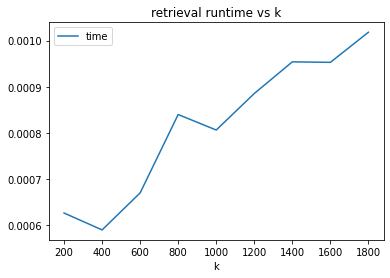

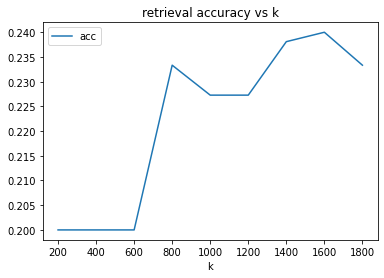

In [ ]:
df_results3 = pd.DataFrame(results3)
df_results3.plot(x='k', y='time', title='retrieval runtime vs k')
df_results3.plot(x='k', y='acc', title='retrieval accuracy vs k')
# df_results3.plot(x='acc', y='time', title='retrieval accuracy vs runtime', kind='scatter')
df_results3.to_csv('accuracy_vs_runtime.csv')

In [ ]:
df_results3

,k,acc,time
0,500,0.215839,18.544873
1,1000,0.222222,11.150702
2,1500,0.229021,10.160948
3,2000,0.233333,10.613082
4,2500,0.232051,12.394096
5,3000,0.230769,10.954199
6,3500,0.233333,11.864406
7,4000,0.250000,10.874898
8,4500,0.239048,13.370205


100%|██████████| 5/5 [00:00<00:00, 41363.94it/s]

100%|██████████| 5/5 [00:00<00:00, 33447.40it/s]

100%|██████████| 5/5 [00:00<00:00, 32214.32it/s]

100%|██████████| 5/5 [00:00<00:00, 39125.97it/s]

100%|██████████| 5/5 [00:00<00:00, 34894.38it/s]

100%|██████████| 5/5 [00:00<00:00, 38130.04it/s]

100%|██████████| 5/5 [00:00<00:00, 29916.58it/s]

100%|██████████| 5/5 [00:00<00:00, 41859.32it/s]

100%|██████████| 5/5 [00:00<00:00, 36921.69it/s]

100%|██████████| 5/5 [00:00<00:00, 24847.77it/s]

100%|██████████| 5/5 [00:00<00:00, 41201.41it/s]

100%|██████████| 5/5 [00:00<00:00, 31347.56it/s]

100%|██████████| 5/5 [00:00<00:00, 44057.82it/s]

100%|██████████| 5/5 [00:00<00:00, 40329.85it/s]

100%|██████████| 5/5 [00:00<00:00, 38980.52it/s]

100%|██████████| 5/5 [00:00<00:00, 35128.17it/s]

100%|██████████| 5/5 [00:00<00:00, 41201.41it/s]

100%|██████████| 5/5 [00:00<00:00, 30705.01it/s]

100%|██████████| 5/5 [00:00<00:00, 42366.71it/s]

100%|██████████| 5/5 [00:00<00:00, 37650.84it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4414


100%|██████████| 5/5 [00:00<00:00, 46500.04it/s]

100%|██████████| 5/5 [00:00<00:00, 58579.66it/s]

100%|██████████| 5/5 [00:00<00:00, 49344.75it/s]

100%|██████████| 5/5 [00:00<00:00, 58416.49it/s]

100%|██████████| 5/5 [00:00<00:00, 46707.17it/s]

100%|██████████| 5/5 [00:00<00:00, 47446.88it/s]

100%|██████████| 5/5 [00:00<00:00, 61320.23it/s]

100%|██████████| 5/5 [00:00<00:00, 43509.38it/s]

100%|██████████| 5/5 [00:00<00:00, 51909.70it/s]

100%|██████████| 5/5 [00:00<00:00, 37718.56it/s]

100%|██████████| 5/5 [00:00<00:00, 31726.96it/s]

100%|██████████| 5/5 [00:00<00:00, 59747.92it/s]

100%|██████████| 5/5 [00:00<00:00, 40329.85it/s]

100%|██████████| 5/5 [00:00<00:00, 52824.99it/s]

100%|██████████| 5/5 [00:00<00:00, 48545.19it/s]

100%|██████████| 5/5 [00:00<00:00, 41610.16it/s]

100%|██████████| 5/5 [00:00<00:00, 48321.47it/s]

100%|██████████| 5/5 [00:00<00:00, 31347.56it/s]

100%|██████████| 5/5 [00:00<00:00, 48770.98it/s]

100%|██████████| 5/5 [00:00<00:00, 34721.06it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4473166666666667


100%|██████████| 5/5 [00:00<00:00, 41610.16it/s]

100%|██████████| 5/5 [00:00<00:00, 45590.26it/s]

100%|██████████| 5/5 [00:00<00:00, 33716.27it/s]

100%|██████████| 5/5 [00:00<00:00, 43151.28it/s]

100%|██████████| 5/5 [00:00<00:00, 40407.55it/s]

100%|██████████| 5/5 [00:00<00:00, 45789.34it/s]

100%|██████████| 5/5 [00:00<00:00, 40021.98it/s]

100%|██████████| 5/5 [00:00<00:00, 34894.38it/s]

100%|██████████| 5/5 [00:00<00:00, 36986.81it/s]

100%|██████████| 5/5 [00:00<00:00, 41527.76it/s]

100%|██████████| 5/5 [00:00<00:00, 40642.48it/s]

100%|██████████| 5/5 [00:00<00:00, 9967.45it/s]

100%|██████████| 5/5 [00:00<00:00, 48433.07it/s]

100%|██████████| 5/5 [00:00<00:00, 43151.28it/s]

100%|██████████| 5/5 [00:00<00:00, 55627.37it/s]

100%|██████████| 5/5 [00:00<00:00, 45003.26it/s]

100%|██████████| 5/5 [00:00<00:00, 47554.47it/s]

100%|██████████| 5/5 [00:00<00:00, 52958.38it/s]

100%|██████████| 5/5 [00:00<00:00, 51025.60it/s]

100%|██████████| 5/5 [00:00<00:00, 59747.92it/s]

1

microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4395833333333334


100%|██████████| 5/5 [00:00<00:00, 42452.47it/s]

100%|██████████| 5/5 [00:00<00:00, 44150.57it/s]

100%|██████████| 5/5 [00:00<00:00, 34952.53it/s]

100%|██████████| 5/5 [00:00<00:00, 44057.82it/s]

100%|██████████| 5/5 [00:00<00:00, 43599.83it/s]

100%|██████████| 5/5 [00:00<00:00, 39053.11it/s]

100%|██████████| 5/5 [00:00<00:00, 43965.45it/s]

100%|██████████| 5/5 [00:00<00:00, 42625.04it/s]

100%|██████████| 5/5 [00:00<00:00, 42027.09it/s]

100%|██████████| 5/5 [00:00<00:00, 51150.05it/s]

100%|██████████| 5/5 [00:00<00:00, 33879.68it/s]

100%|██████████| 5/5 [00:00<00:00, 48433.07it/s]

100%|██████████| 5/5 [00:00<00:00, 48099.82it/s]

100%|██████████| 5/5 [00:00<00:00, 41120.63it/s]

100%|██████████| 5/5 [00:00<00:00, 47127.01it/s]

100%|██████████| 5/5 [00:00<00:00, 32413.48it/s]

100%|██████████| 5/5 [00:00<00:00, 42027.09it/s]

100%|██████████| 5/5 [00:00<00:00, 49344.75it/s]

100%|██████████| 5/5 [00:00<00:00, 51275.11it/s]

100%|██████████| 5/5 [00:00<00:00, 41363.94it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.43231666666666674


100%|██████████| 5/5 [00:00<00:00, 62601.55it/s]

100%|██████████| 5/5 [00:00<00:00, 44243.71it/s]

100%|██████████| 5/5 [00:00<00:00, 51781.53it/s]

100%|██████████| 5/5 [00:00<00:00, 48770.98it/s]

100%|██████████| 5/5 [00:00<00:00, 48770.98it/s]

100%|██████████| 5/5 [00:00<00:00, 46397.17it/s]

100%|██████████| 5/5 [00:00<00:00, 39420.15it/s]

100%|██████████| 5/5 [00:00<00:00, 43690.67it/s]

100%|██████████| 5/5 [00:00<00:00, 53362.65it/s]

100%|██████████| 5/5 [00:00<00:00, 51150.05it/s]

100%|██████████| 5/5 [00:00<00:00, 43965.45it/s]

100%|██████████| 5/5 [00:00<00:00, 50901.75it/s]

100%|██████████| 5/5 [00:00<00:00, 55627.37it/s]

100%|██████████| 5/5 [00:00<00:00, 53092.46it/s]

100%|██████████| 5/5 [00:00<00:00, 46603.38it/s]

100%|██████████| 5/5 [00:00<00:00, 45491.37it/s]

100%|██████████| 5/5 [00:00<00:00, 49578.06it/s]

100%|██████████| 5/5 [00:00<00:00, 56679.78it/s]

100%|██████████| 5/5 [00:00<00:00, 52692.26it/s]

100%|██████████| 5/5 [00:00<00:00, 50655.85it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4350833333333334


100%|██████████| 5/5 [00:00<00:00, 43240.25it/s]

100%|██████████| 5/5 [00:00<00:00, 42196.22it/s]

100%|██████████| 5/5 [00:00<00:00, 53498.78it/s]

100%|██████████| 5/5 [00:00<00:00, 51025.60it/s]

100%|██████████| 5/5 [00:00<00:00, 42196.22it/s]

100%|██████████| 5/5 [00:00<00:00, 41692.88it/s]

100%|██████████| 5/5 [00:00<00:00, 36033.54it/s]

100%|██████████| 5/5 [00:00<00:00, 8483.62it/s]

100%|██████████| 5/5 [00:00<00:00, 41692.88it/s]

100%|██████████| 5/5 [00:00<00:00, 44810.94it/s]

100%|██████████| 5/5 [00:00<00:00, 50778.50it/s]

100%|██████████| 5/5 [00:00<00:00, 47554.47it/s]

100%|██████████| 5/5 [00:00<00:00, 60090.32it/s]

100%|██████████| 5/5 [00:00<00:00, 60436.66it/s]

100%|██████████| 5/5 [00:00<00:00, 53635.60it/s]

100%|██████████| 5/5 [00:00<00:00, 24672.38it/s]

100%|██████████| 5/5 [00:00<00:00, 42366.71it/s]

100%|██████████| 5/5 [00:00<00:00, 46916.15it/s]

100%|██████████| 5/5 [00:00<00:00, 48321.47it/s]

100%|██████████| 5/5 [00:00<00:00, 45990.18it/s]

1

microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.43566666666666676


100%|██████████| 5/5 [00:00<00:00, 48884.66it/s]

100%|██████████| 5/5 [00:00<00:00, 38621.58it/s]

100%|██████████| 5/5 [00:00<00:00, 13860.89it/s]

100%|██████████| 5/5 [00:00<00:00, 38621.58it/s]

100%|██████████| 5/5 [00:00<00:00, 45990.18it/s]

100%|██████████| 5/5 [00:00<00:00, 33026.02it/s]

100%|██████████| 5/5 [00:00<00:00, 50291.41it/s]

100%|██████████| 5/5 [00:00<00:00, 46397.17it/s]

100%|██████████| 5/5 [00:00<00:00, 49461.13it/s]

100%|██████████| 5/5 [00:00<00:00, 40880.16it/s]

100%|██████████| 5/5 [00:00<00:00, 54613.33it/s]

100%|██████████| 5/5 [00:00<00:00, 48657.82it/s]

100%|██████████| 5/5 [00:00<00:00, 45392.90it/s]

100%|██████████| 5/5 [00:00<00:00, 36792.14it/s]

100%|██████████| 5/5 [00:00<00:00, 37249.59it/s]

100%|██████████| 5/5 [00:00<00:00, 40175.33it/s]

100%|██████████| 5/5 [00:00<00:00, 42281.29it/s]

100%|██████████| 5/5 [00:00<00:00, 46916.15it/s]

100%|██████████| 5/5 [00:00<00:00, 44150.57it/s]

100%|██████████| 5/5 [00:00<00:00, 49695.55it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.43900000000000006


100%|██████████| 5/5 [00:00<00:00, 51653.99it/s]

100%|██████████| 5/5 [00:00<00:00, 48998.88it/s]

100%|██████████| 5/5 [00:00<00:00, 47021.35it/s]

100%|██████████| 5/5 [00:00<00:00, 57772.78it/s]

100%|██████████| 5/5 [00:00<00:00, 38479.85it/s]

100%|██████████| 5/5 [00:00<00:00, 39053.11it/s]

100%|██████████| 5/5 [00:00<00:00, 39869.81it/s]

100%|██████████| 5/5 [00:00<00:00, 33078.11it/s]

100%|██████████| 5/5 [00:00<00:00, 37382.39it/s]

100%|██████████| 5/5 [00:00<00:00, 48770.98it/s]

100%|██████████| 5/5 [00:00<00:00, 44243.71it/s]

100%|██████████| 5/5 [00:00<00:00, 50171.10it/s]

100%|██████████| 5/5 [00:00<00:00, 45197.24it/s]

100%|██████████| 5/5 [00:00<00:00, 52298.05it/s]

100%|██████████| 5/5 [00:00<00:00, 41943.04it/s]

100%|██████████| 5/5 [00:00<00:00, 46091.25it/s]

100%|██████████| 5/5 [00:00<00:00, 51400.78it/s]

100%|██████████| 5/5 [00:00<00:00, 36157.79it/s]

100%|██████████| 5/5 [00:00<00:00, 52298.05it/s]

100%|██████████| 5/5 [00:00<00:00, 28532.68it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4450333333333334


100%|██████████| 5/5 [00:00<00:00, 38692.84it/s]

100%|██████████| 5/5 [00:00<00:00, 35484.81it/s]

100%|██████████| 5/5 [00:00<00:00, 28886.39it/s]

100%|██████████| 5/5 [00:00<00:00, 11403.76it/s]

100%|██████████| 5/5 [00:00<00:00, 15709.00it/s]

100%|██████████| 5/5 [00:00<00:00, 25206.15it/s]

100%|██████████| 5/5 [00:00<00:00, 36220.24it/s]

100%|██████████| 5/5 [00:00<00:00, 10255.02it/s]

100%|██████████| 5/5 [00:00<00:00, 10732.61it/s]

100%|██████████| 5/5 [00:00<00:00, 41943.04it/s]

100%|██████████| 5/5 [00:00<00:00, 34778.64it/s]

100%|██████████| 5/5 [00:00<00:00, 35848.75it/s]

100%|██████████| 5/5 [00:00<00:00, 34323.27it/s]

100%|██████████| 5/5 [00:00<00:00, 39199.10it/s]

100%|██████████| 5/5 [00:00<00:00, 22075.28it/s]

100%|██████████| 5/5 [00:00<00:00, 19204.69it/s]

100%|██████████| 5/5 [00:00<00:00, 41120.63it/s]

100%|██████████| 5/5 [00:00<00:00, 52692.26it/s]

100%|██████████| 5/5 [00:00<00:00, 46500.04it/s]

100%|██████████| 5/5 [00:00<00:00, 50412.31it/s]



microsoft/beit-base-patch16-224-pt22k-ft22k Accuracy:  0.4449


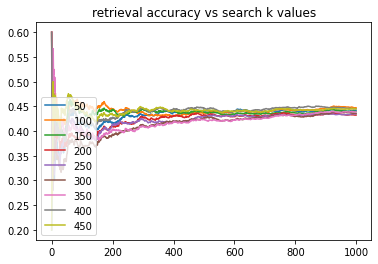

In [ ]:
results3 = defaultdict(list)

for k in k_values:
  test_accuracies = []
  for identity in tqdm(identity_selection):
    base_image_idx = random.choice(identity_to_idx[identity])
    close_image_idx = index.get_nns_by_item(base_image_idx, 5, search_k=k, include_distances=False)
    test_accuracies.append(retrival_accuracy(base_image_idx, close_image_idx, idx_to_identity, identity_to_idx))
    acc = np.mean(test_accuracies)
    results3[k].append(acc)
  print(model_identifier, 'Accuracy: ', acc)


df_results3 = pd.DataFrame(results3)
df_results3.plot(title='retrieval accuracy vs search k values')
df_results3.to_csv('accuracy_vs_search_k_18k.csv')

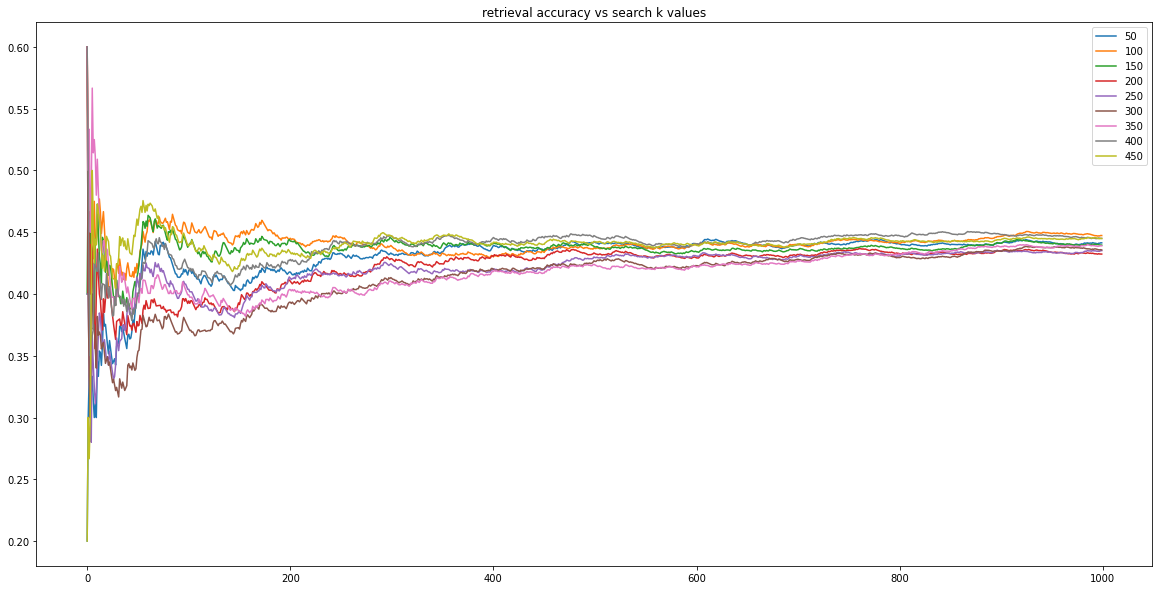

In [ ]:
df_results3 = pd.DataFrame(results3)
df_results3.plot(title='retrieval accuracy vs search k values', figsize=(20,10))

DEBUGGING

In [ ]:

df, identity_selection = prepare_dataset(n_identities=1000)
model, feature_extractor, dim = init_model(identifier='microsoft/beit-base-patch16-224-pt22k-ft22k')
print('building annoy index...')
idx_to_identity = df.to_dict('index')
identity_to_idx = defaultdict(list) 
index = AnnoyIndex(dim, 'euclidean')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k, v in idx_to_identity.items():
  identity_to_idx[v["identity"]].append(k)

# Batching
images, keys = [], []
for k, v in idx_to_identity.items():
  images.append(Image.open("img_align_celeba/img_align_celeba/" + v["file"]))
  keys.append(k)

print('num images:', len(images))
batch_size = 25
for i in tqdm(range(0, len(images), batch_size)):
  batch_im, batch_keys = images[i:i+batch_size], keys[i:i+batch_size]
  batch_encodings = feature_extractor(images=batch_im, return_tensors="pt")
  batch_pixel_values = batch_encodings['pixel_values'].to(device)
  batch_outputs = model(batch_pixel_values).logits
  for i, embedding in enumerate(batch_outputs):
    index.add_item(batch_keys[i], embedding.squeeze())

# single input
"""
for k, v in tqdm(idx_to_identity.items()):
  im = Image.open("img_align_celeba/img_align_celeba/" + v["file"])
  encoding = feature_extractor(images=im, return_tensors="pt")
  pixel_values = encoding['pixel_values'].to(device)
  embedding = model(pixel_values).logits 
  index.add_item(k, embedding.squeeze())
"""




loading data...
microsoft/beit-base-patch16-224-pt22k-ft22k
building annoy index...
num images: 19172


100%|██████████| 767/767 [07:56<00:00,  1.61it/s]


'\nfor k, v in tqdm(idx_to_identity.items()):\n  im = Image.open("img_align_celeba/img_align_celeba/" + v["file"])\n  encoding = feature_extractor(images=im, return_tensors="pt")\n  pixel_values = encoding[\'pixel_values\'].to(device)\n  embedding = model(pixel_values).logits \n  index.add_item(k, embedding.squeeze())\n'